In [130]:
import re
import os
import pandas as pd
pd.set_option('display.max_column',None)
from statistics import mode
from collections import Counter
import gspread
from google.oauth2.service_account import Credentials
import math
import matplotlib.pyplot as plt

In [131]:
# Calulating mod avg.

def mod_avg(numbers):
    frequency = Counter(numbers)
    max_frequency = max(frequency.values())
    modes = [num for num, freq in frequency.items() if freq == max_frequency]
    average_mode = sum(modes) / len(modes)
    return int(average_mode)

In [132]:
def parse_file(file_path, date, df, haemoglobin_sample, factor):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    sample_id = file_path[20:25]
    device_id = re.search(r'Device ID:(\w+)', lines[1]).group(1)
    base_readings = []
    test_readings = []
    current_case = None
    repetition_no = None
    collecting_test_data = False

    for i, line in enumerate(lines):
        if 'Collecting base data' in line:
            for j in range(i + 1, i + 16):
                base_readings.append(int(lines[j].split(',')[0]))

        elif 'Repetition No. :' in line:
            repetition_no = int(line.split(':')[1].strip())

        elif '[Mixer Mix]' in line:
            current_case = 'Mixer Mix'
            collecting_test_data = True

        elif '[Hand-MIX]' in line:
            current_case = 'Hand Mix'
            collecting_test_data = True

        elif 'Collecting test data' in line:
            if collecting_test_data:
                for j in range(i + 1, i + 181):
                    test_readings.append(int(lines[j].split(',')[0]))

                # Extracting the numeric part of the sample ID
                numeric_sample_id = re.search(r'\d+', sample_id).group(0)

                # Adding sample id, device id, date, repetition no., case
                row = {
                    'Sample ID': sample_id,
                    'Device ID': device_id,
                    'Date': date,
                    'Repetition No.': repetition_no,
                    'Case': current_case
                }

                # Adding mod_avg_base_data
                row.update({f'base_data_mod_avg': mod_avg(base_readings)})
                # Adding mod_avg_test_data
                row.update({f'test_data_mod_avg': mod_avg(test_readings[-15:])})
                # Adding actual conc.
                row.update({f'actual': haemoglobin_sample[int(numeric_sample_id) + 1]})
                # Adding absorption
                row.update({f'absorption': round(math.log10(row['base_data_mod_avg'] / row['test_data_mod_avg']), 4)})
                # Adding concentration
                row.update({f'concentration': round(factor * row['absorption'], 2)})
                # Adding error%
                row.update({f'error%': round((abs(float(row['actual']) - row['concentration']) / float(row['actual'])) * 100, 2)})
                # Adding base readings
                row.update({f'Base Data {i + 1}': base_readings[i] for i in range(15)})
                # Adding test readings
                row.update({f'Test Data {i + 1}': test_readings[i] for i in range(180)})

                temp_df = pd.DataFrame([row])
                df = pd.concat([df, temp_df], ignore_index=True)
                collecting_test_data = False
                test_readings = []

    return df

In [133]:
# connecting sheets
SERVICE_ACCOUNT_FILE = 'mobilabhemoglobinhandvsmixer-215a0e65c2f2.json'
SCOPES = ["https://www.googleapis.com/auth/spreadsheets", "https://www.googleapis.com/auth/drive"]
credentials = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
gc = gspread.authorize(credentials)

spreadsheet1 = gc.open('Haemoglobin Sample ID info')
sheet1 = spreadsheet1.sheet1
haemoglobin_sample = sheet1.col_values(17)

spreadsheet2 = gc.open('sample')
output_sheet = spreadsheet2.sheet1


base_data_columns = [f'Base Data {i+1}' for i in range(15)]
test_data_columns = [f'Test Data {i+1}' for i in range(180)]
columns = ['Sample ID', 'Device ID', 'Date', 'Repetition No.', 'Case'] + ['base_data_mod_avg', 'test_data_mod_avg', 'actual', 'absorption', 'concentration', 'error%'] + base_data_columns + test_data_columns
df = pd.DataFrame(columns=columns)


zip_path = '14-5-24'
factor = int(input())

for files in os.listdir(zip_path):
    file_path = zip_path + '/' + files
    date = zip_path
    df = parse_file(file_path, date, df, haemoglobin_sample, factor)

df.tail()

# df.to_csv(f'{zip_path}.xlsx', index=False)

,Sample ID,Device ID,Date,Repetition No.,Case,base_data_mod_avg,test_data_mod_avg,actual,absorption,concentration,error%,Base Data 1,Base Data 2,Base Data 3,Base Data 4,Base Data 5,Base Data 6,Base Data 7,Base Data 8,Base Data 9,Base Data 10,Base Data 11,Base Data 12,Base Data 13,Base Data 14,Base Data 15,Test Data 1,Test Data 2,Test Data 3,Test Data 4,Test Data 5,Test Data 6,Test Data 7,Test Data 8,Test Data 9,Test Data 10,Test Data 11,Test Data 12,Test Data 13,Test Data 14,Test Data 15,Test Data 16,Test Data 17,Test Data 18,Test Data 19,Test Data 20,Test Data 21,Test Data 22,Test Data 23,Test Data 24,Test Data 25,Test Data 26,Test Data 27,Test Data 28,Test Data 29,Test Data 30,Test Data 31,Test Data 32,Test Data 33,Test Data 34,Test Data 35,Test Data 36,Test Data 37,Test Data 38,Test Data 39,Test Data 40,Test Data 41,Test Data 42,Test Data 43,Test Data 44,Test Data 45,Test Data 46,Test Data 47,Test Data 48,Test Data 49,Test Data 50,Test Data 51,Test Data 52,Test Data 53,Test Data 54,Test Data 55,Test Data 56,Test Data 57,Test Data 58,Test Data 59,Test Data 60,Test Data 61,Test Data 62,Test Data 63,Test Data 64,Test Data 65,Test Data 66,Test Data 67,Test Data 68,Test Data 69,Test Data 70,Test Data 71,Test Data 72,Test Data 73,Test Data 74,Test Data 75,Test Data 76,Test Data 77,Test Data 78,Test Data 79,Test Data 80,Test Data 81,Test Data 82,Test Data 83,Test Data 84,Test Data 85,Test Data 86,Test Data 87,Test Data 88,Test Data 89,Test Data 90,Test Data 91,Test Data 92,Test Data 93,Test Data 94,Test Data 95,Test Data 96,Test Data 97,Test Data 98,Test Data 99,Test Data 100,Test Data 101,Test Data 102,Test Data 103,Test Data 104,Test Data 105,Test Data 106,Test Data 107,Test Data 108,Test Data 109,Test Data 110,Test Data 111,Test Data 112,Test Data 113,Test Data 114,Test Data 115,Test Data 116,Test Data 117,Test Data 118,Test Data 119,Test Data 120,Test Data 121,Test Data 122,Test Data 123,Test Data 124,Test Data 125,Test Data 126,Test Data 127,Test Data 128,Test Data 129,Test Data 130,Test Data 131,Test Data 132,Test Data 133,Test Data 134,Test Data 135,Test Data 136,Test Data 137,Test Data 138,Test Data 139,Test Data 140,Test Data 141,Test Data 142,Test Data 143,Test Data 144,Test Data 145,Test Data 146,Test Data 147,Test Data 148,Test Data 149,Test Data 150,Test Data 151,Test Data 152,Test Data 153,Test Data 154,Test Data 155,Test Data 156,Test Data 157,Test Data 158,Test Data 159,Test Data 160,Test Data 161,Test Data 162,Test Data 163,Test Data 164,Test Data 165,Test Data 166,Test Data 167,Test Data 168,Test Data 169,Test Data 170,Test Data 171,Test Data 172,Test Data 173,Test Data 174,Test Data 175,Test Data 176,Test Data 177,Test Data 178,Test Data 179,Test Data 180
55,S1737,VB7GRD50,14-5-24,8,Hand Mix,11087,5917,10.3,0.2727,0.27,97.38,11092,11087,11087,11083,11087,11086,11085,11081,11077,11081,11079,11082,11087,11075,11076,5898,5917,5907,5903,5902,5897,5890,5887,5898,5913,5930,5926,5934,5931,5940,5954,5935,5911,5911,5937,5939,5941,5934,5947,5937,5798,5831,5949,5937,5936,5911,5921,5909,5933,5932,5923,5942,5935,5916,5923,5923,5912,5910,5854,5901,5881,5923,5923,5937,5927,5933,5935,5945,5923,5915,5940,5951,5929,5949,5954,5950,5967,5955,5956,5945,5945,5949,5954,5957,5939,5941,5945,5949,5963,5956,5950,5955,5955,5952,5957,5957,5951,5925,5954,5942,5949,5942,5955,5954,5938,5939,5944,5945,5931,5941,5946,5945,5946,5897,5941,5940,5963,5949,5957,5970,5954,5951,5966,5963,5943,5947,5934,5949,5983,5946,5945,5908,5923,5936,5951,5945,5935,5944,5944,5938,5941,5950,5918,5925,5943,5931,5927,5919,5931,5921,5928,5937,5929,5917,5932,5936,5919,5887,5919,5943,5933,5936,5927,5930,5916,5927,5925,5927,5916,5909,5920,5911,5932,5925,5925,5929,5929,5941,5925,5927,5929,5907,5917,5914,5917,5921,5919,5925,5914,5924,5934,5939,5935,5943,5921
56,S1737,VB7GRD50,14-5-24,9,Mixer Mix,11087,4838,10.3,0.3601,0.36,96.50,11092,11087,11087,11083,11087,11086,11085,11081,11077,11081,11079,11082,11087,11075,11076,6023,6005,5985,5975,5963,5945,5922,5895,5866,5827,5796,577

In [141]:
df

,Sample ID,Device ID,Date,Repetition No.,Case,base_data_mod_avg,test_data_mod_avg,actual,absorption,concentration,error%,Base Data 1,Base Data 2,Base Data 3,Base Data 4,Base Data 5,Base Data 6,Base Data 7,Base Data 8,Base Data 9,Base Data 10,Base Data 11,Base Data 12,Base Data 13,Base Data 14,Base Data 15,Test Data 1,Test Data 2,Test Data 3,Test Data 4,Test Data 5,Test Data 6,Test Data 7,Test Data 8,Test Data 9,Test Data 10,Test Data 11,Test Data 12,Test Data 13,Test Data 14,Test Data 15,Test Data 16,Test Data 17,Test Data 18,Test Data 19,Test Data 20,Test Data 21,Test Data 22,Test Data 23,Test Data 24,Test Data 25,Test Data 26,Test Data 27,Test Data 28,Test Data 29,Test Data 30,Test Data 31,Test Data 32,Test Data 33,Test Data 34,Test Data 35,Test Data 36,Test Data 37,Test Data 38,Test Data 39,Test Data 40,Test Data 41,Test Data 42,Test Data 43,Test Data 44,Test Data 45,Test Data 46,Test Data 47,Test Data 48,Test Data 49,Test Data 50,Test Data 51,Test Data 52,Test Data 53,Test Data 54,Test Data 55,Test Data 56,Test Data 57,Test Data 58,Test Data 59,Test Data 60,Test Data 61,Test Data 62,Test Data 63,Test Data 64,Test Data 65,Test Data 66,Test Data 67,Test Data 68,Test Data 69,Test Data 70,Test Data 71,Test Data 72,Test Data 73,Test Data 74,Test Data 75,Test Data 76,Test Data 77,Test Data 78,Test Data 79,Test Data 80,Test Data 81,Test Data 82,Test Data 83,Test Data 84,Test Data 85,Test Data 86,Test Data 87,Test Data 88,Test Data 89,Test Data 90,Test Data 91,Test Data 92,Test Data 93,Test Data 94,Test Data 95,Test Data 96,Test Data 97,Test Data 98,Test Data 99,Test Data 100,Test Data 101,Test Data 102,Test Data 103,Test Data 104,Test Data 105,Test Data 106,Test Data 107,Test Data 108,Test Data 109,Test Data 110,Test Data 111,Test Data 112,Test Data 113,Test Data 114,Test Data 115,Test Data 116,Test Data 117,Test Data 118,Test Data 119,Test Data 120,Test Data 121,Test Data 122,Test Data 123,Test Data 124,Test Data 125,Test Data 126,Test Data 127,Test Data 128,Test Data 129,Test Data 130,Test Data 131,Test Data 132,Test Data 133,Test Data 134,Test Data 135,Test Data 136,Test Data 137,Test Data 138,Test Data 139,Test Data 140,Test Data 141,Test Data 142,Test Data 143,Test Data 144,Test Data 145,Test Data 146,Test Data 147,Test Data 148,Test Data 149,Test Data 150,Test Data 151,Test Data 152,Test Data 153,Test Data 154,Test Data 155,Test Data 156,Test Data 157,Test Data 158,Test Data 159,Test Data 160,Test Data 161,Test Data 162,Test Data 163,Test Data 164,Test Data 165,Test Data 166,Test Data 167,Test Data 168,Test Data 169,Test Data 170,Test Data 171,Test Data 172,Test Data 173,Test Data 174,Test Data 175,Test Data 176,Test Data 177,Test Data 178,Test Data 179,Test Data 180
0,S1740,VB7GRD50,14-5-24,1,Mixer Mix,11061,7045,7.6,0.1959,0.20,97.37,11061,11061,11060,11060,11059,11060,11057,11053,11057,11061,11065,11066,11061,11059,11054,7036,7031,7023,7017,7022,7037,7055,7056,7051,7049,7046,7060,7063,7053,7049,7037,7045,7062,7020,7030,7057,7064,7071,7081,7051,6636,6667,7093,7115,7085,7076,7069,7060,7055,7062,7035,7007,7047,7049,7059,7050,7035,7039,7046,7021,7025,7058,7065,7069,7060,7068,7048,7069,7067,7075,7045,7050,7063,7057,7047,7048,7045,7057,7060,7042,7058,7053,7057,7054,7070,7057,7042,7061,7034,7023,7026,7029,7049,7057,7036,7048,7040,7043,7031,7050,7039,7035,7066,7042,7050,7048,7063,7044,7050,7039,7011,7057,7058,7071,7069,7059,7047,7025,6999,7034,7051,7050,7061,7055,7057,7058,7061,7056,7054,7009,7041,7024,7004,7041,7052,7031,7059,7065,7057,7053,7056,7057,7055,7017,6979,6990,7024,7062,7061,7064,7056,7071,7055,7054,7068,7053,7059,7062,7040,7053,7029,7006,7050,7072,7057,7045,7054,7053,6988,7061,7072,7036,7040,7056,7063,7053,7066,7061,7071,7067,7069,7072,7042,7039,7049,7055,7041,7045,7029,7039,7045,7058,7069,7071,7045
1,S1740,VB7GRD50,14-5-24,1,Hand Mix,11061,7046,7.6,0.1959,0.20,97.37,11061,11061,11060,11060,11059,11060,11057,11053,11057,11061,11065,11066,11061,11059,11054,7019,7013,6993,6987,6977,7014,7019,7024,6999,7018,7027,7028,70

30 30 30 30


Text(0, 0.5, 'sin(x)')

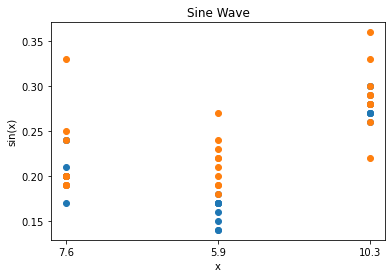

In [142]:
x1 = df['actual'][df['Case']=='Hand Mix']
y1 = df['concentration'][df['Case']=='Hand Mix']
x2 = df['actual'][df['Case']=='Mixer Mix']
y2 = df['concentration'][df['Case']=='Mixer Mix']
print(len(x1), len(y1), len(x2), len(y2))

# Create a figure and plot
fig, ax = plt.subplots()
ax.scatter(x1, y1)
ax.scatter(x2, y2)

# Customize the plot
ax.set_title('Sine Wave')
ax.set_xlabel('x')
ax.set_ylabel('sin(x)')

# Display the plot in Streamlit
st.pyplot(fig)